In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import csv
import datetime

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #ez hogy a rákban nem a defaultja a jupyternek?

In [3]:
def createNxGraph(filename):
    """
    G = nx.Graph()
    with open(filename, 'r') as inputfile:
        csvr = csv.reader(inputfile, delimiter=',')
        next(csvr) # we don't want to read the header, so we skip it
        for line in csvr:
            # we add an edge between the ID of the proposition
            # and the ID of the MEP
            amendment = (line[0],datetime.datetime.strptime(line[3], "%d/%m/%Y"))
            mep = (line[6],line[7],line[8],line[9],line[10])
            G.add_node(amendment, bipartite = 0)
            G.add_node(mep, bipartite = 1)
            G.add_edge(amendment, mep)
    return G
    """
    # we put `keep_default_na` here so that nan-s get parsed in the way we want
    df = pd.read_csv(filename, header = 0, keep_default_na = False)
    G = nx.from_pandas_edgelist(df, source='AmendmentID', target='OfficialMEPID')
    return G

def listMEPs(filename):
    """
    L = []
    with open(filename, 'r') as inputfile:
        csvr = csv.reader(inputfile, delimiter=',')
        next(csvr) # we don't want to read the header, so we skip it
        for line in csvr:
            mep = (line[6],line[7],line[8],line[9],line[10])
            L.append(mep)
    return L
    """
    df = pd.read_csv(filename, header = 0, keep_default_na = False)
    o = pd.unique(df["OfficialMEPID"])
    print(type(o))
    return o

In [4]:
print(createNxGraph("db/ep_cosponsorship_dataset.csv"))

Graph with 259357 nodes and 750578 edges


In [5]:
print(listMEPs("db/ep_cosponsorship_dataset.csv"))

<class 'numpy.ndarray'>
['124704' '197572' '94649' '96725' '197770' '113892' '96711' '37324'
 '197721' '197719' '125042' '197718' '197935' '197530' '125064' '197593'
 '96867' '96810' '124785' '188636' '125706' '197767' '23788' '197538'
 '96713' '24922' '124708' '197444' '183916' '128483' '197463' '197788'
 '197799' '197597' '124831' '197806' '124780' '197482' '197826' '197547'
 '197504' '191693' '197512' '124862' '197848' '125045' '197556' '124738'
 '197629' '183793' '97198' '197621' '125012' '197647' '124802' '197824'
 '96772' '197427' '197422' '124808' '24594' '28115' '197773' '96891'
 '124846' '28389' '197518' '197846' '197651' '189525' '197434' '197743'
 '125023' '1917' '88715' '132191' '197533' '197822' '190518' '197787'
 '125046' '197697' '96730' '197554' '197700' '197577' '118949' '197815'
 '197437' '2187' '124693' '197531' '124835' '197616' '197825' '221463'
 '28400' '189065' '197505' '197585' '192634' '197808' '124586' '124734'
 '2309' '96951' '197501' '197655' '22858' '197494

In [6]:
myGraph = createNxGraph("db/ep_cosponsorship_dataset.csv")
list_meps = listMEPs("db/ep_cosponsorship_dataset.csv")

<class 'numpy.ndarray'>


In [7]:
print(f"Some information about this graph:\n"
        f"Number of nodes: {nx.number_of_nodes(myGraph)}\n"
        f"Number of edges: {nx.number_of_edges(myGraph)}\n")

print(f"The nodes in this graph include: {list(myGraph.nodes)[:100]}")

# now amendments are 'int's and MEPS are 'string's.

Some information about this graph:
Number of nodes: 259357
Number of edges: 750578

The nodes in this graph include: [892323, '124704', 880086, '197572', 885326, '94649', 891589, '96725', 881777, '197770', 888406, '113892', 890457, '96711', 894926, 893171, 892450, 894881, 893914, 893108, '37324', 894291, 883936, '197721', '197719', '125042', '197718', 889291, 885412, 884461, 879904, 890644, 879857, '197935', 885362, 891635, '197530', 880857, '125064', 888150, '197593', 886342, 887149, 888086, '96867', 893879, '96810', 893221, '124785', 887654, '188636', 894783, '125706', 881778, 884421, 893372, '197767', '23788', '197538', '96713', 893286, 884484, 880531, 886091, 885447, 888054, 881629, 886288, '24922', 882597, 884341, 891348, 879855, '124708', '197444', 884436, 893420, 879923, 888314, 893432, '183916', 881668, 893827, '128483', 892452, 885460, 889480, '197463', 880572, '197788', '197799', '197597', '124831', '197806', '124780', '197482', 894188, 892355, 881707, 894626]


In [8]:
nx.is_bipartite(myGraph)


True

In [9]:
# most már lefut elég gyorsan !
mep_social_network = nx.algorithms.bipartite.projected_graph(myGraph, list_meps)

In [10]:
print(mep_social_network.nodes())

['124704', '197572', '94649', '96725', '197770', '113892', '96711', '37324', '197721', '197719', '125042', '197718', '197935', '197530', '125064', '197593', '96867', '96810', '124785', '188636', '125706', '197767', '23788', '197538', '96713', '24922', '124708', '197444', '183916', '128483', '197463', '197788', '197799', '197597', '124831', '197806', '124780', '197482', '197826', '197547', '197504', '191693', '197512', '124862', '197848', '125045', '197556', '124738', '197629', '183793', '97198', '197621', '125012', '197647', '124802', '197824', '96772', '197427', '197422', '124808', '24594', '28115', '197773', '96891', '124846', '28389', '197518', '197846', '197651', '189525', '197434', '197743', '125023', '1917', '88715', '132191', '197533', '197822', '190518', '197787', '125046', '197697', '96730', '197554', '197700', '197577', '118949', '197815', '197437', '2187', '124693', '197531', '124835', '197616', '197825', '221463', '28400', '189065', '197505', '197585', '192634', '197808', '

In [11]:
deg_hist = nx.degree_histogram(myGraph)
deg_hist


[0,
 134299,
 32769,
 20866,
 16829,
 13583,
 9798,
 8115,
 5789,
 4525,
 3260,
 2349,
 1982,
 1370,
 780,
 829,
 461,
 359,
 182,
 130,
 85,
 52,
 71,
 55,
 84,
 5,
 4,
 0,
 7,
 1,
 0,
 1,
 0,
 2,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 2,
 0,
 2,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 2,
 2,
 1,
 1,
 1,
 1

In [12]:
degs = dict(myGraph.degree())

sorted_nodes = sorted(degs.items(), key=lambda x: x[1], reverse=True)
sorted_nodes[:10]

[('197463', 5155),
 ('197702', 4483),
 ('202073', 4350),
 ('197635', 4245),
 ('124785', 4200),
 ('58766', 3914),
 ('197446', 3650),
 ('134605', 3544),
 ('197732', 3533),
 ('197663', 3491)]

Akkor I guess ezek a legaktívabb EP képviselők. Jár nekik a keksz.

A következő fokszám gyakoriság ábrán csak a 0 és 20 kozotti ertekek látszodnak rendesen (bár amik nem egy számjegyű a gyakoriságuk azon fokszámok kb 1 és 25 közt vannak)

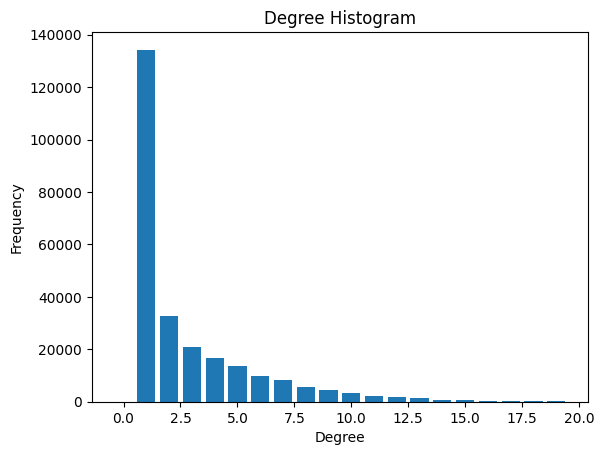

In [13]:
plt.bar(list(x for x in range(len(deg_hist[:20]))), deg_hist[:20], align='center')
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

Esetleg latvanyosabb ha azt mondjuk hogy kizárjuk az 1 fokszámot, merthogy az csak 1 ember javaslata/ 1 db javaslat (A többi 25 - nél nagyobb fokszám pedig nagyjából mind 0,1,2,3 gyakoriságú)

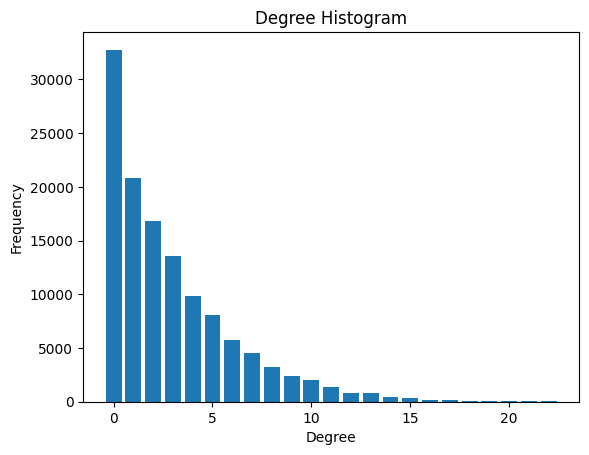

In [14]:
plt.bar(list(x for x in range(len(deg_hist[2:25]))), deg_hist[2:25], align='center')
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [15]:
### melyik ország politikusai csináltak többet?

contribs_by_country = {}

for node in myGraph.nodes():
    if len(node) == 5: # ez egy nagyon maszek módja hogy csak az emberkéket nézzük
        if node[2] not in contribs_by_country:
            contribs_by_country[node[2]] = 0
        #print(node)
        contribs_by_country[node[2]] += myGraph.degree(node)

TypeError: object of type 'int' has no len()

Az üres string ország politikusai nem tudom mit reprezentálnak.

In [20]:
### melyik évben mennyit dolgoztak?


contribs_by_year = {}

for node in myGraph.nodes():
    if len(node) == 2: # ez egy nagyon maszek módja hogy csak az amendmenteket nézzük
        if node[1].year not in contribs_by_year:
            contribs_by_year[node[1].year] = 0
        #print(node)
        #contribs_by_year[node[1].year] += myGraph.degree(node)
        contribs_by_year[node[1].year] += 1
        
contribs_by_year

TypeError: object of type 'int' has no len()

Nem igazán látszik se a COVID se az ukrajnai háború hatása a kontribúciók számában.

## MEP_SOCIAL_NETWORK

In [21]:
mep_social_network

In [22]:
print(f"Some information about this graph:\n"
        f"Number of nodes: {nx.number_of_nodes(mep_social_network)}\n"
        f"Number of edges: {nx.number_of_edges(mep_social_network)}\n")

Some information about this graph:
Number of nodes: 754
Number of edges: 21576



### By years 2020 and 2021

Let us create 2 social network graphs corresponding to the years 2020 and 2021

In [23]:
df = pd.read_csv('db/ep_cosponsorship_dataset.csv', header = 0, keep_default_na = False)
df2020 = df[df['Date'].str.contains("2020") == True]
df2021 = df[df['Date'].str.contains("2021") == True]

list_meps_2020 = pd.unique(df2020["OfficialMEPID"])
list_meps_2021 = pd.unique(df2021["OfficialMEPID"])


In [24]:
myGraph2020 = nx.from_pandas_edgelist(df2020, source='AmendmentID', target='OfficialMEPID')
myGraph2021 = nx.from_pandas_edgelist(df2021, source='AmendmentID', target='OfficialMEPID')


print(f'The 2020 Graph is biparted : {nx.is_bipartite(myGraph2020)}')
print(f'The 2021 Graph is biparted : {nx.is_bipartite(myGraph2021)}')


The 2020 Graph is biparted : True
The 2021 Graph is biparted : True


In [25]:
mep_social_network_2020 = nx.algorithms.bipartite.projected_graph(myGraph2020, list_meps_2020)
mep_social_network_2021 = nx.algorithms.bipartite.projected_graph(myGraph2021, list_meps_2021)

Consider some famous and important centrality measures: Degree centrality, betweenness centrality, eigenvector centrality 

For 2020:

In [26]:
Deg_Cent_2020_UnSort = nx.degree_centrality(mep_social_network_2020)
Eig_Cent_2020_UnSort = nx.eigenvector_centrality(mep_social_network_2020, max_iter=1000, tol=1e-06, nstart=None, weight=None)
Btw_Cent_2020_UnSort = nx.betweenness_centrality(mep_social_network_2020, k=None, normalized=True, weight=None, endpoints=False, seed=None)

Sorting them by value

In [27]:
Deg_Cent_2020 = sorted(Deg_Cent_2020_UnSort.items(), key=lambda x:x[1], reverse=True)
Eig_Cent_2020 = sorted(Eig_Cent_2020_UnSort.items(), key=lambda x:x[1], reverse=True)
Btw_Cent_2020 = sorted(Btw_Cent_2020_UnSort.items(), key=lambda x:x[1], reverse=True)


For 2021:

In [28]:
Deg_Cent_2021_UnSort = nx.degree_centrality(mep_social_network_2021)
Eig_Cent_2021_UnSort = nx.eigenvector_centrality(mep_social_network_2021, max_iter=1000, tol=1e-06, nstart=None, weight=None)
Btw_Cent_2021_UnSort = nx.betweenness_centrality(mep_social_network_2021, k=None, normalized=True, weight=None, endpoints=False, seed=None)

Sorting them by value

In [29]:
Deg_Cent_2021 = sorted(Deg_Cent_2021_UnSort.items(), key=lambda x:x[1], reverse=True)
Eig_Cent_2021 = sorted(Eig_Cent_2021_UnSort.items(), key=lambda x:x[1], reverse=True)
Btw_Cent_2021 = sorted(Btw_Cent_2021_UnSort.items(), key=lambda x:x[1], reverse=True)

Let us look at betweenness centrality first

In [30]:
x = [Btw_Cent_2020[i][0] for i in range(len(Btw_Cent_2020[:10]))] # top 10 MEP according to betweenness centrality in 2020
y1 = [Btw_Cent_2020_UnSort[x[i]] for i in range(len(x)) ]         #betweenness centrality values top 10 MEP in 2020
y2=[]                                                             #betweenness centrality values top 10 MEP in 2021
for i in range(len(x)):
    try: 
        y2.append(Btw_Cent_2021_UnSort[x[i]])
    except: 
        y2.append(0)
          

print(Btw_Cent_2021[:10])
print(x)
print(y1)
print(y2)

[('197614', 0.03838145248439457), ('96867', 0.034510072729735185), ('197523', 0.03425607711855597), ('197790', 0.03235720122000254), ('', 0.02974096548954125), ('198490', 0.02655334393897524), ('123562', 0.021131013290033966), ('124766', 0.0198647770416676), ('192635', 0.01890592245214629), ('197670', 0.017531289428355256)]
['197806', '124785', '124812', '', '28266', '197493', '124738', '197532', '132191', '96903']
[0.02722228881442316, 0.024537698080261714, 0.024215151613408495, 0.02337123997200883, 0.022662956720020857, 0.02200047085090896, 0.021599358034329476, 0.01771816852255001, 0.016340702505876877, 0.015133587585353114]
[0.0041774485721426564, 0.006768634422964896, 0.008666286663841402, 0.02974096548954125, 0.0013860384123385605, 0.0009615391997285037, 0.005511462676472655, 0.0007849790587171985, 0.0031378363519803253, 0.005653924643841413]


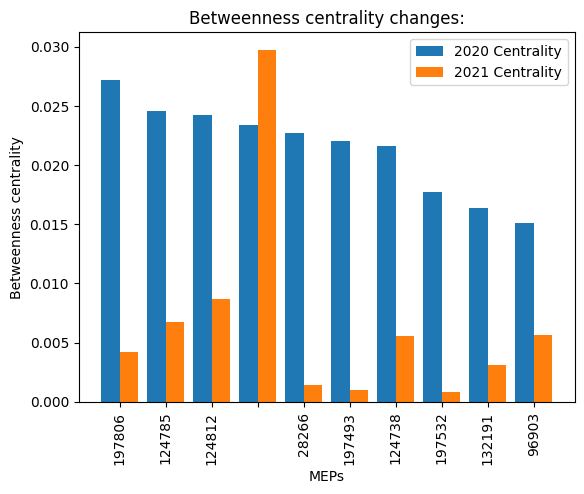

In [31]:
X_axis = np.arange(len(x))

plt.bar(X_axis - 0.2, y1, 0.4, label = '2020 Centrality')
plt.bar(X_axis + 0.2, y2, 0.4, label = '2021 Centrality')
  
plt.xticks(X_axis, x, rotation = 90)
plt.xlabel("MEPs")
plt.ylabel("Betweenness centrality")
plt.title("Betweenness centrality changes:")
plt.legend()
plt.show()

Basically the above graph represents the betweenness centrality changes for the top 10 EMPs (according to measurments from 2020)

Let us look at also at Eigenvector Centrality but now let us observe the centrality measures in 2020, for the top 10 most influencial MEPs (according to 2021 measurments). That is who were the benificiary of the changes from 2020 to 2021.

In [35]:
x = [Eig_Cent_2021[i][0] for i in range(len(Eig_Cent_2021[:10]))] # top 10 MEP according to eigenvector centrality in 2021
y2 = [Eig_Cent_2021_UnSort[x[i]] for i in range(len(x)) ]         #eigenvector centrality values top 10 MEP in 2021
y1=[]                                                             #eigenvector centrality values top 10 MEP in 2020
for i in range(len(x)):
    try: 
        y1.append(Eig_Cent_2020_UnSort[x[i]])
    except: 
        y1.append(0)
          

print(Eig_Cent_2021[:10])
print(x)
print(y1)
print(y2)

[('130100', 0.14858573701749217), ('197567', 0.1392665190249663), ('197463', 0.13083224892664938), ('202073', 0.13044955737238353), ('197523', 0.1296341678266221), ('103746', 0.12412865421228003), ('197869', 0.12349891163756983), ('134605', 0.1196878023456399), ('', 0.10857996764910478), ('209091', 0.10802263633633685)]
['130100', '197567', '197463', '202073', '197523', '103746', '197869', '134605', '', '209091']
[0.12842530091982832, 0.09931017676123369, 0.10006083952973675, 0.09293407125797892, 0.0729441666992619, 0.08813788434324722, 0.08174617803466834, 0.08166004537342293, 0.0833743509462057, 0]
[0.14858573701749217, 0.1392665190249663, 0.13083224892664938, 0.13044955737238353, 0.1296341678266221, 0.12412865421228003, 0.12349891163756983, 0.1196878023456399, 0.10857996764910478, 0.10802263633633685]


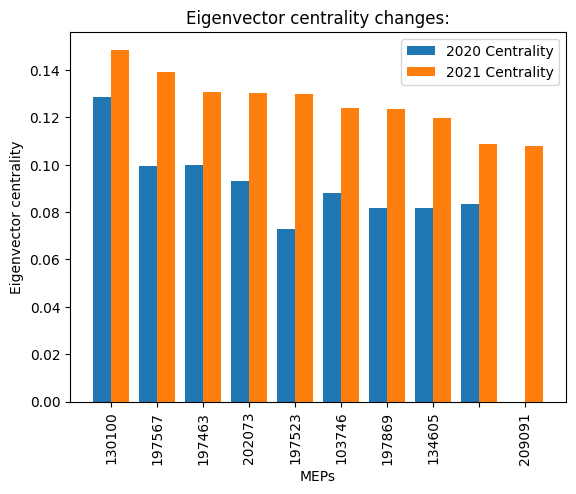

In [36]:
X_axis = np.arange(len(x))

plt.bar(X_axis - 0.2, y1, 0.4, label = '2020 Centrality')
plt.bar(X_axis + 0.2, y2, 0.4, label = '2021 Centrality')
  
plt.xticks(X_axis, x, rotation = 90)
plt.xlabel("MEPs")
plt.ylabel("Eigenvector centrality")
plt.title("Eigenvector centrality changes:")
plt.legend()
plt.show()